In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# for feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preparation
1. Feature Selection
2. Splitting into train and test data
3. Feature Engineering

## Feature Selection:
Before actually selecting existing features, I want to extract the titles from the name column

In [4]:
titles = df['Name'].str.extract(',\s(\w+)\.')
titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Don           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Sir           1
dtype: int64

Because there are a lot of different titles, I want to reduce them to five. This includes Mr, Miss, Mrs and Master, since there are already a lot observations. This means I have to match the other titles into the existing groups. I map them like this:
* `Mlle` and `Ms` to `Miss` 
* `Mme` to `Mrs`
* `Dr`, `Rev`, `Col`, `Major`, `Capt`, `Jonkheer`, `Lady` and `Sir` to `rest`

In [6]:
df['title'] = titles.replace({
     'Mlle': 'Miss', 
     'Ms': 'Miss', 
     'Mme': 'Mrs', 
     'Dr': 'rest', 
     'Don': 'rest',
     'Rev': 'rest', 
     'Col': 'rest', 
     'Major': 'rest', 
     'Capt': 'rest', 
     'Jonkheer': 'rest', 
     'Lady': 'rest', 
     'Sir': 'rest'
})
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,titles,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


Now that I got information about the titles of each passenger I have all the features I want to train my model.

In [116]:
y = df['Survived']
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'title', 'SibSp']]

<AxesSubplot:>

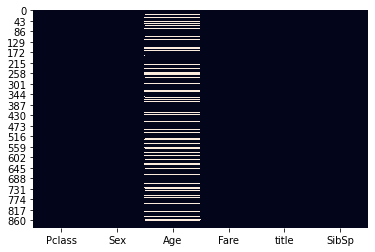

In [117]:
sns.heatmap(X.isnull(), cbar=False)

In [120]:
# Checking for missing values
X.isna().any()

Pclass    False
Sex       False
Age        True
Fare      False
title     False
SibSp     False
dtype: bool

Checking titles, since I am responsible for that.  
Turns out my regex missed the Countess of somewhat which I would put into the titles-group `rest`.

In [119]:
X.loc[X['title'].isna()]
df.iloc[759]
X['title'].iloc[759] = 'rest'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## Splitting the dataset into train and test

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Feature Engineering
1. Impute missing `age` value, then binning them into 5 groups
2. Scaling the `fare` into a range of 0 to 1
3. HotEncoding the `titles` and `sex`

In [188]:
impute_and_bin_age = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense', strategy = 'quantile')
)

In [189]:
feat_eng = ColumnTransformer(
    transformers = [
        ('age_transformation', impute_and_bin_age, ['Age']),
        ('fare_scaling', MinMaxScaler(), ['Fare', 'SibSp']),
        ('hot_titles', OneHotEncoder(), ['title', 'Sex']),
    ],
    remainder = 'passthrough'
)

In [190]:
feat_eng.fit(X_train)
X_train_trans = feat_eng.transform(X_train)
X_train_trans

array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 3.],
       [0., 1., 0., ..., 0., 1., 2.],
       ...,
       [0., 1., 0., ..., 1., 0., 3.],
       [1., 0., 0., ..., 0., 1., 3.],
       [1., 0., 0., ..., 1., 0., 3.]])

# Train the model:

In [191]:
# Initializing the model
model = LogisticRegression(max_iter=10000)

# Fitting the model on training data
model.fit(X_train_trans, y_train)

LogisticRegression(max_iter=10000)

In [192]:
# Transform the test data
X_test_trans = feat_eng.transform(X_test)

# calculate predictions
y_pred = model.predict(X_test_trans)



0.8251121076233184

# Evaluation

In [193]:
from sklearn import metrics

In [203]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(t_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy} \n Precision: {precision}\n Recall: {recall}\n F1 Score: {f1_score}')

AttributeError: module 'sklearn.metrics' has no attribute 'precision'

In [196]:
metrics.confusion_matrix(y_test, y_pred)

array([[120,  21],
       [ 18,  64]])

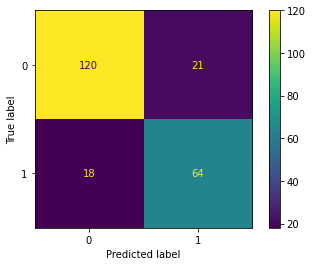

In [197]:
metrics.plot_confusion_matrix(model, X_test_trans, y_test)

In [199]:
metrics.recall_score(y_test, y_pred)

0.7804878048780488

In [200]:
metrics.f1_score(y_test, y_pred)

0.7664670658682634

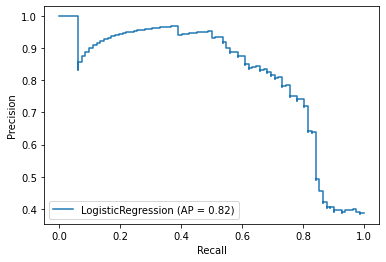

In [201]:
metrics.plot_precision_recall_curve(model, X_test_trans, y_test)

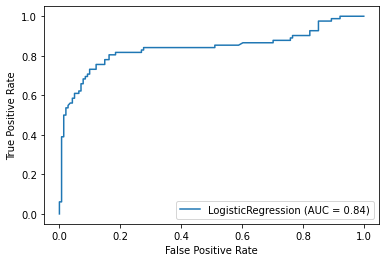

In [202]:
metrics.plot_roc_curve(model, X_test_trans, y_test)